In [8]:
import re, gensim, pickle, operator
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline

In [10]:
# load data
data_folder = '../data/csv_export/'
util_folder = '../util/'
trend_folder = '../data/trends/'
df_organizations = pd.read_csv(data_folder + 'organizations.csv'.format(data_folder), dtype={'first_funding_on': str, 'last_funding_on':str})
df_description = pd.read_csv(data_folder + 'organization_descriptions.csv')
df_funding_rounds = pd.read_csv(data_folder + 'funding_rounds.csv')
df_funds = pd.read_csv(data_folder + 'funds.csv')
df_investments = pd.read_csv(data_folder + 'investments.csv')
df_acq = pd.read_csv(data_folder + 'acquisitions.csv')
df_competition = pd.read_csv(data_folder + 'competitors.csv')
df_category = pd.read_csv(data_folder + 'category_groups.csv')
df_investors = pd.read_csv(data_folder + 'investors.csv')

In [ ]:
# 각 카테고리에 속하는 회사들의 펀딩 찍어보기
# 회사-카테고리 매핑
df_category = df_organizations[['uuid','category_list']]
print(df_category.head())

In [ ]:
# 카테고리 리스트를 개별 카테고리로 나눠서 dataframe 으로 만든다
df2 = df_category['category_list'].str.split('|').apply(pd.Series, 1).stack()
df2.index = df2.index.droplevel(-1)
df2.name = 'category_list'
del df_category['category_list']
df_category = df_category.join(df2)
df_category.columns = ['uuid', 'category']
df_category.head()

In [ ]:
# 각 회사의 투자 정보를 불러온다
df_funding = df_funding_rounds[['company_uuid', 'funding_round_uuid', 'announced_on']]
df_funding = df_funding.merge(df_category, left_on = 'company_uuid', right_on = 'uuid', how = 'inner')
df_funding = df_funding.drop('uuid', axis = 1)
df_funding.columns = ['company_uuid', 'funding_round_uuid', 'date', 'category']
df_funding['year-month'] = df_funding['date'].str[:7]
df_funding.head()

In [ ]:
# 각 회사에 투자한 투자사들의 정보를 합친다
df_investment = pd.DataFrame(df_investments[['funding_round_uuid', 'investor_uuid']].groupby('funding_round_uuid')['investor_uuid'].apply(list)).reset_index()
df_funding = df_funding.merge(df_investment, on = 'funding_round_uuid')
df_funding.head()

In [ ]:
# 가장 많이 사용된 탑 10 카테고리
df_category_count = pd.read_csv('../data/others/category_count.csv')
print(df_category_count.head(10))

# # csv 파일이 없을 시 다음의 코드로 저장할 수 있다
# df_funding.groupby('category').size().rename('count').reset_index().sort_values('count', ascending = False).to_csv('../data/others/category_count.csv', index = False)

In [ ]:
# crunchbase 의 카테고리 정보로 빠른 투자자들 찾기
def get_early_investors_by_categories(categories, early_investment_percent = 10, top_k = 30,verbose = True):
    color1 = 'blue'
    if type(categories) == str:
        categories = [categories]

    # 펀딩 정보중 겹치는 데이터를 뺀다
    df = df_funding[df_funding['category'].isin(categories)].drop_duplicates('funding_round_uuid')

    # 그래프를 그리기 위한 전처리
    start_year = min(df['year-month'].values)[:4]
    count = df.groupby('year-month').size().rename('count').reset_index()
    for year in range(int(start_year), 2018):
        year = str(year)
        if count[count['year-month'] == '{}-01'.format(year)].shape[0] == 0:
            count.loc[-1] = ['{}-01'.format(year), 0]
            count.index = count.index + 1
    count['year'] = np.where(True, count['year-month'].str[:4], '')
    count = count.sort_values('year-month')
    count['cum_count'] = count['count'].cumsum()
    if verbose:
        print('categories: {}'.format(categories))

    # 가장 빠른 상위 top_k 퍼센트의 투자만 고른다
    dates = sorted(df['date'].values, reverse = False)
    fast_date = dates[int(float(early_investment_percent) / 100 * len(dates))]
    if verbose:
        print "Early {} percent investors before {} \n({} early fundings out of {} total)".format(early_investment_percent, fast_date, int(float(early_investment_percent) / 100 * len(dates)), len(dates))
    df_fast = df[df['date'] < fast_date]
    
    # 투자자 리스트를 개별 투자자의 형태로 dataframe 을 변형한다
    df_fast2 = df_fast['investor_uuid'].apply(pd.Series, 1).stack()
    df_fast2.index = df_fast2.index.droplevel(-1)
    df_fast2.name = 'investor_uuid'
    del df_fast['investor_uuid']
    df_fast = df_fast.join(df_fast2)
    
    # 첫 투자 날을 기억해
    df_fast3 = df_fast.groupby('investor_uuid')['year-month'].min().rename('date').reset_index()

    # 가장 많은 투자를 한 투자자 순으로 출력한다
    score = df_fast.groupby('investor_uuid').size().rename('count').reset_index().sort_values('count', ascending = False)
    score = score.merge(df_investors[['investor_name', 'uuid']], how = 'inner', left_on = 'investor_uuid', right_on = 'uuid')
    score = score.merge(df_fast3, on = 'investor_uuid')
    score2 = score.drop(['investor_uuid', 'uuid'], axis = 1)
    if verbose:
        print score2.head(top_k)
        print score2.shape
        count[['year-month', 'cum_count']].plot(x = count['year'], linestyle = '-', color = [color1], fontsize = 25, figsize = (30, 8)).legend(loc = 2, fontsize = 20, labels = ['funding count'])
    return score

In [ ]:
# company description 에 있는 단어 기반으로 해당 단어에 관련된 회사들에 빨리 투자한 투자자 찾기
def get_early_investors_by_words(words, early_investment_percent = 10, top_k = 30, expand = False, verbose = True):
    color1 = 'blue'
    
    # load required dataset
    if 'word2company' not in globals():
        print('loading word2company')
        global word2company
        word2company = pickle.load(open(util_folder + 'word2company.pickle'))
    if 'model' not in globals():
        print('loading word2vec model')
        global model
        model = gensim.models.word2vec.Word2Vec.load(util_folder + 'word2vec')

    # expand word set if necessary
    # train 된 word2vec 을 사용하여 관련도가 높은 단어들을 포함한다
    final_words = []
    if type(words) == str:
        words = [words]
#     print words
    for word in words:
        if ' ' in word:
            word = word.replace(' ', '_')
        if expand:
            if word not in model: continue
            _words = model.most_similar(word)
            _words = [str(_word) for _word, sim in _words]
            final_words.extend(_words)
        final_words.append(word)
    final_words = list(set(final_words))
    
    # choose companies that have relevant words
    companies = []
    for word in final_words:
        _companies = word2company.get(word, [])
        companies.extend(_companies)
    companies = list(set(companies))
#     print final_words, len(companies)
    # 펀딩 정보중 필요한 회사들만 취하고, 겹치는 데이터를 뺀다
    df = df_funding[df_funding['company_uuid'].isin(companies)].drop_duplicates('funding_round_uuid')
    
    if df.shape[0] < 10:
        return pd.DataFrame()
    
    # 그래프를 그리기 위한 전처리
    start_year = min(df['year-month'].values)[:4]
    count = df.groupby('year-month').size().rename('count').reset_index()
    for year in range(int(start_year), 2018):
        year = str(year)
        if count[count['year-month'] == '{}-01'.format(year)].shape[0] == 0:
            count.loc[-1] = ['{}-01'.format(year), 0]
            count.index = count.index + 1
    count['year'] = np.where(True, count['year-month'].str[:4], '')
    count = count.sort_values('year-month')
    count['cum_count'] = count['count'].cumsum()
    if verbose:
        print('Keywords: {}'.format(final_words))

    # 가장 빠른 상위 top_k 퍼센트의 투자만 고른다
    dates = sorted(df['date'].values, reverse = False)
    fast_date = dates[int(float(early_investment_percent) / 100 * len(dates))]
    if verbose:    
        print "Early {} percent investors before {} \n({} early fundings out of {} total)".format(early_investment_percent, fast_date, int(float(early_investment_percent) / 100 * len(dates)), len(dates))
    df_fast = df[df['date'] < fast_date]
    
    # 투자자 리스트를 개별 투자자의 형태로 dataframe 을 변형한다
    df_fast2 = df_fast['investor_uuid'].apply(pd.Series, 1).stack()
    df_fast2.index = df_fast2.index.droplevel(-1)
    df_fast2.name = 'investor_uuid'
    del df_fast['investor_uuid']
    df_fast = df_fast.join(df_fast2)
    
    # 첫 투자 날을 기억해
    df_fast3 = df_fast.groupby('investor_uuid')['year-month'].min().rename('date').reset_index()

    # 가장 많은 투자를 한 투자자 순으로 출력한다
    score = df_fast.groupby('investor_uuid').size().rename('count').reset_index().sort_values('count', ascending = False)
    score = score.merge(df_investors[['investor_name', 'uuid']], how = 'inner', left_on = 'investor_uuid', right_on = 'uuid')
    score = score.merge(df_fast3, on = 'investor_uuid')
    score2 = score.drop(['investor_uuid', 'uuid'], axis = 1)
    if verbose:        
        print score2.head(top_k)
        print score2.shape
        count[['year-month', 'cum_count']].plot(x = count['year'], linestyle = '-', color = [color1], fontsize = 25, figsize = (30, 8)).legend(loc = 2, fontsize = 20, labels = ['funding count'])
    return score

In [ ]:
def get_early_investors(words, early_investment_percent = 10, top_k = 30):
    get_early_investors_by_categories(words, early_investment_percent = 10, top_k = 30)
    get_early_investors_by_words(words, early_investment_percent = 10, top_k = 30)

In [ ]:
# 모든 카테고리에 대해서 빠른 회사들 찾아서 저장
# 모든 단어에 대해서 빠른 회사들 찾아서 저장
category_min = 10
word_min = 10

save_category = False
save_word = True

if save_category:
    df_category_count = pd.read_csv('../data/others/category_count.csv')
    category2investor = {}
    investor2category = {}

    df_category_count = df_category_count[df_category_count['count'] >= category_min]
    categories = df_category_count['category'].values
    for index, category in enumerate(categories):
        if index % (len(categories) // 10) == 0:
            print index, len(categories)
        if type(category) != str: continue
        score = get_early_investors_by_categories(category, early_investment_percent = 10, top_k = 30, verbose = False)

        investors = score['investor_uuid'].values
        category2investor[category] = investors
        for investor in investors:
            if investor not in investor2category:
                investor2category[investor] = []
            investor2category[investor].append(category)
    with open('../data/others/category2investor.pickle', 'w') as f:
        pickle.dump(category2investor, f)
    with open('../data/others/investor2category.pickle', 'w') as f:
        pickle.dump(investor2category, f)

    for category, investors in category2investor.items():
        print category
        print investors
        break
    
if save_word:
    # load required dataset
    if 'word2company' not in globals():
        print('loading word2company')
        global word2company
        word2company = pickle.load(open(util_folder + 'word2company.pickle'))
    if 'company2word' not in globals():
        print('loading company2word')
        global company2word
        company2word = pickle.load(open(util_folder + 'company2word.pickle'))

    word2investor = {}
    investor2word = {}

    words = word2company.keys()
    for index, word in enumerate(words):
        if index % (len(words) // 100) == 0:
            print index, len(words)
        if len(word2company[word]) < word_min: continue            
            
        score = get_early_investors_by_words([word], early_investment_percent = 10, top_k = 30, verbose = False)
#         print word, score.shape
        if score.shape[0] == 0: continue
        investors = score['investor_uuid'].values
        word2investor[word] = investors
        for investor in investors:
            if investor not in investor2word:
                investor2word[investor] = []
            investor2word[investor].append(word)
    with open('../data/others/word2investor.pickle', 'w') as f:
        pickle.dump(word2investor, f)
    with open('../data/others/investor2word.pickle', 'w') as f:
        pickle.dump(investor2word, f)

    for word, investors in word2investor.items():
        print word
        print investors
        break

In [ ]:
# TOP VC 들에 대해서 그들의 
category2investor = pickle.load(open('../data/others/category2investor.pickle'))
investor2category = pickle.load(open('../data/others/investor2category.pickle'))

word2investor = pickle.load(open('../data/others/word2investor.pickle'))
investor2word = pickle.load(open('../data/others/investor2word.pickle'))

central = pickle.load(open(util_folder + 'investor_centrality_degree.pickle'))

top20 = [uuid for uuid, value in central[:10]]
for i, uuid in enumerate(top20):
    print df_investors[df_investors['uuid'] == (uuid)]['investor_name'], central[i][1]
    print investor2category.get(uuid, [])
    print investor2word.get(uuid, [])

In [ ]:
'''
industry sector 찾기
company clustering


'''






# def get_categories_from_words(words):
#     THRESHOLD = 0.6
#     if 'model' not in globals():
#         print('loading word2vec model')
#         global model
#         model = gensim.models.word2vec.Word2Vec.load(util_folder + 'word2vec')
    
#     categories = pickle.load(open('../data/others/categories.pickle'))

#     valid_categories = {}
#     # build category to word
#     for category in categories:
#         # if name of the category is larger than 1, only use first two words (bigram)
#         _category = re.sub('[^0-9a-zA-Z]+', ' ', category)

#         if len(_category.split()) > 1:
#             _category = '_'.join(_category.split()[:2])
#         if category in model:
#             valid_categories[category] = _category

#     word_list = valid_categories.values()

#     groups = {0 : [word_list[0]]}
#     next_index = 1
#     for word1 in word_list[1:]:
#         found = False
#         for index, group in groups.items():
#             for word2 in group:
#                 if model.similarity(word1, word2) > THRESHOLD:
#                     found = True
#                     _index = index
#                     break
#             if found:
#                 break
#     #         print 'word1:',word1, found
#         if found:
#             groups[_index].append(word1)
#         else:
#             groups[next_index] = [word1]
#             next_index += 1
#     sorted_groups = sorted(groups.items(), key = lambda i: len(i[1]))
#     #      key=lambda i: i[1][0]
#     sorted_groups.reverse()
#     for index in range(next_index):
#         if len(sorted_groups[index][1]) > 0:
#             for word in sorted_groups[index][1]:
#                 print word
#             print '\n\n'



#     # print('loading word2vec model')
#     # model = gensim.models.word2vec.Word2Vec.load(util_folder + 'word2vec')



#     def get_similar_categories(categories):
#         pass

#     def get_top_categories(k):
#         pass

categories: ['mobile']
Early 10 percent investors before 2007-01-01 
(1227 early fundings out of 12275 total)
    count                                  investor_name     date
0      47                                  Intel Capital  1999-03
1      39                                Sequoia Capital  1999-10
2      35                  Draper Fisher Jurvetson (DFJ)  2000-03
3      32                      New Enterprise Associates  1998-03
4      30                                       Redpoint  2000-12
5      27                                       3i Group  2000-09
6      27                      Bessemer Venture Partners  2000-05
7      23                                  Mayfield Fund  2000-03
8      23                                  Apax Partners  2000-11
9      23                   U.S. Venture Partners (USVP)  2000-01
10     22                                 Accel Partners  1996-12
11     20             Motorola Solutions Venture Capital  2003-04
12     19                       

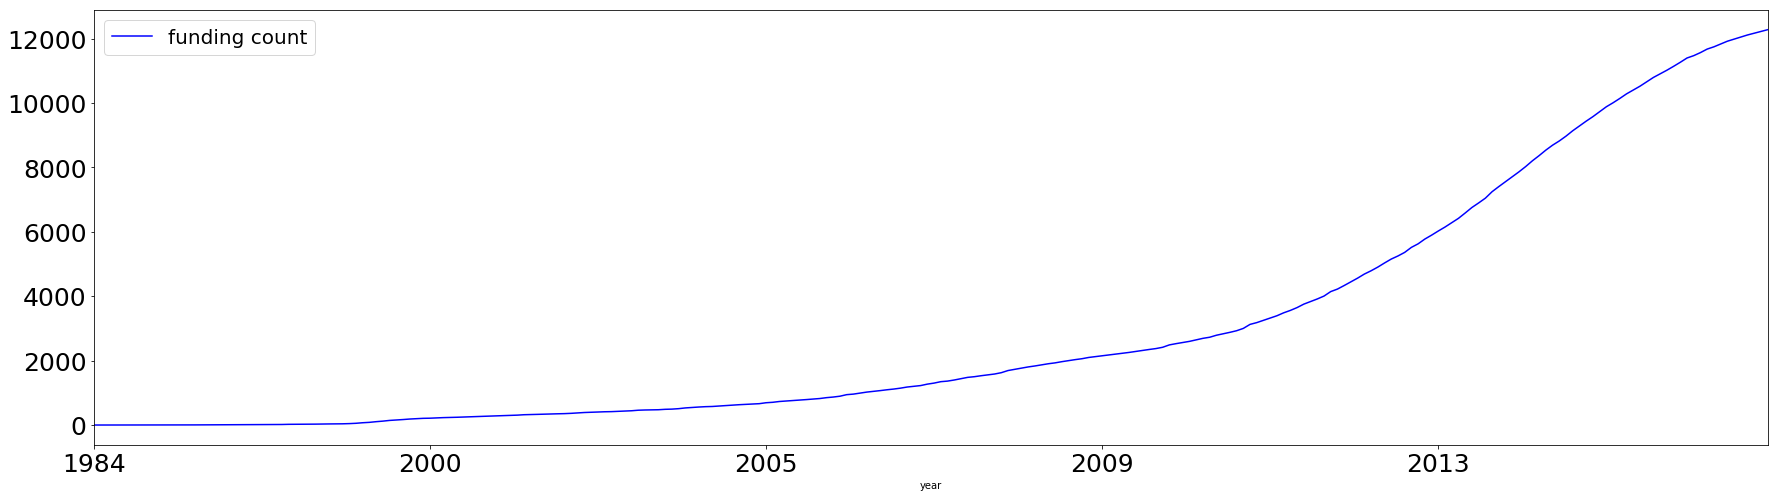

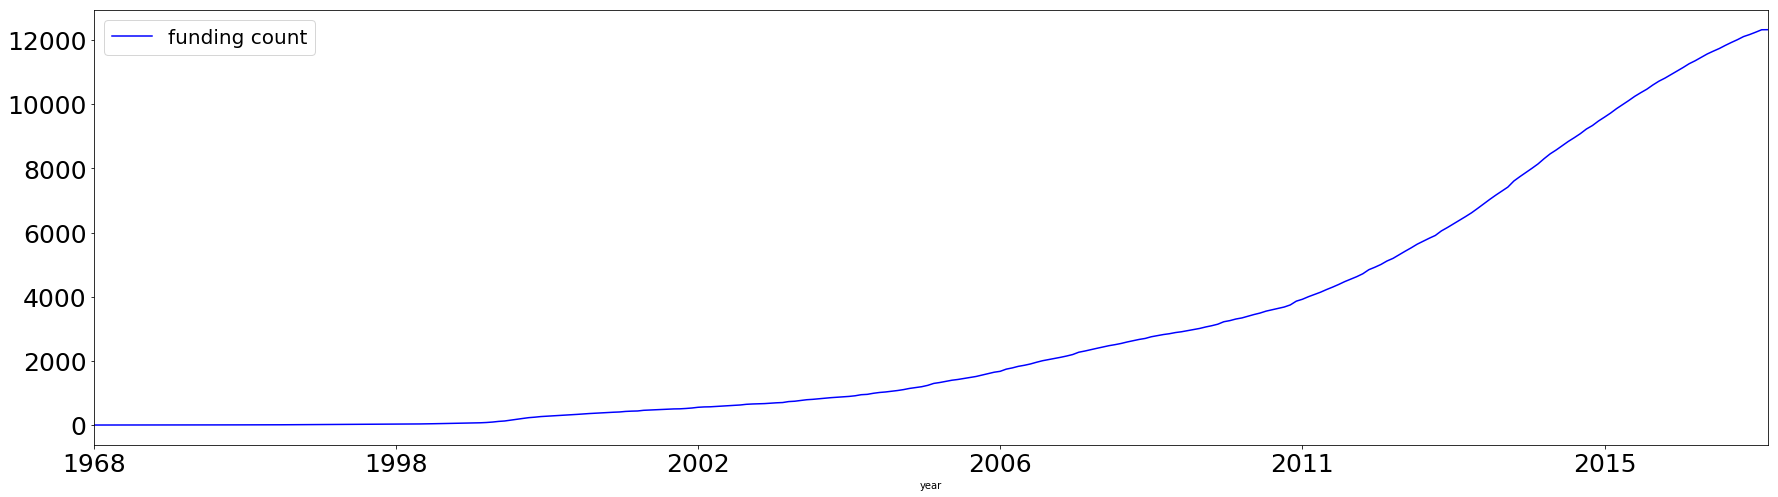

In [97]:
get_early_investors('mobile', early_investment_percent = 10, top_k = 30)

categories: ['fintech']
Early 10 percent investors before 2010-01-26 
(334 early fundings out of 3348 total)
    count                       investor_name     date
0      16                           Techstars  2007-08
1      10                       Intel Capital  2001-10
2       9       Draper Fisher Jurvetson (DFJ)  2003-06
3       9                      Accel Partners  1999-10
4       9                       Goldman Sachs  2000-01
5       9                           Benchmark  2000-08
6       8                   Greylock Partners  2005-05
7       7                     Sequoia Capital  1999-10
8       6           Bessemer Venture Partners  2004-01
9       6      Norwest Venture Partners - NVP  2001-01
10      6               Mohr Davidow Ventures  2000-06
11      6                   Fidelity Ventures  2004-04
12      6                       True Ventures  2006-01
13      6          Advantage Capital Partners  1999-12
14      5                       Icon Ventures  2004-06
15      5  

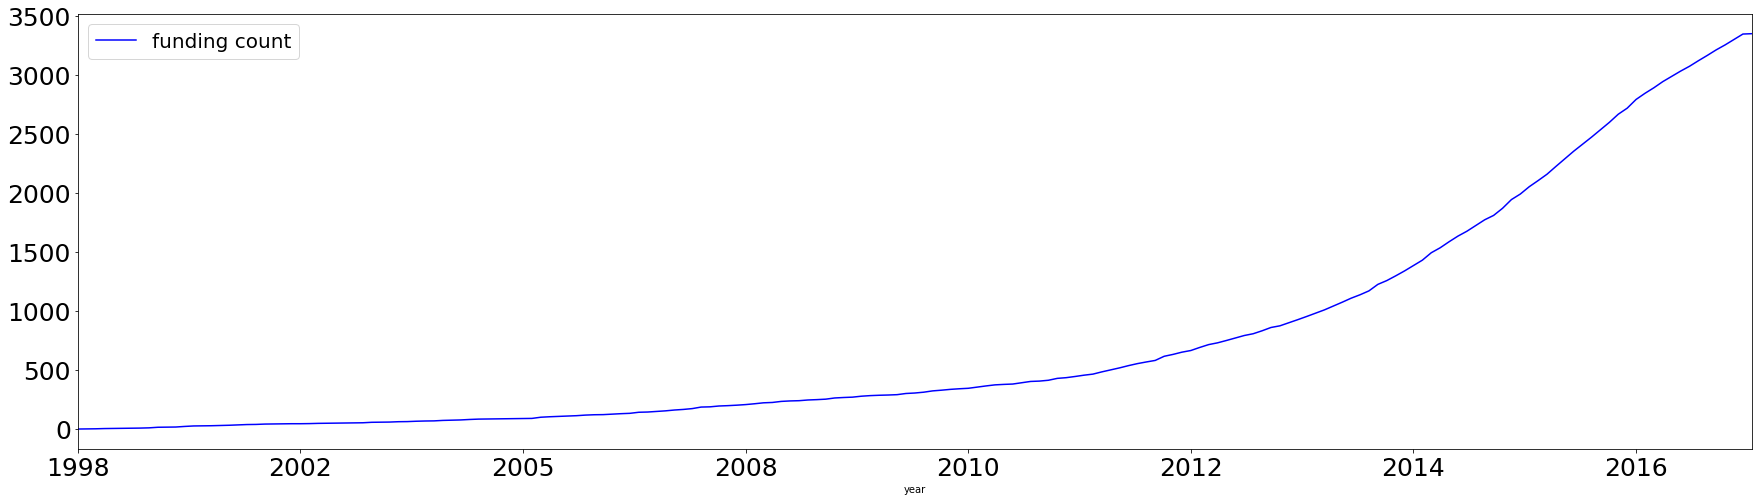

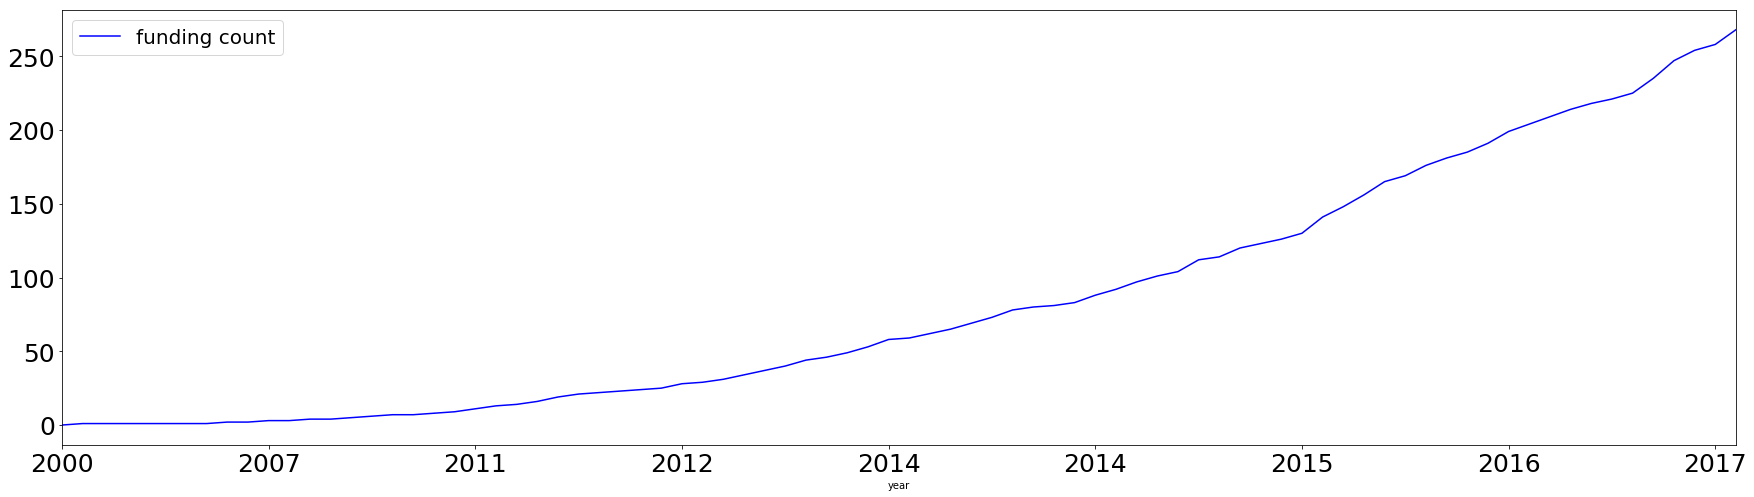

In [98]:
get_early_investors('fintech', early_investment_percent = 10, top_k = 30)

categories: ['artificial intelligence']
Early 10 percent investors before 2012-05-15 
(154 early fundings out of 1542 total)
    count                                      investor_name     date
0       5                                   Cordova Ventures  2002-01
1       5                                      Goldman Sachs  2006-07
2       5                              Mohr Davidow Ventures  2006-11
3       5                                        HIG Capital  2000-09
4       5                                   Felicis Ventures  2006-05
5       5                          Boston Millennia Partners  2002-01
6       4                                 Foundation Capital  2007-04
7       4                                              Wayra  2011-09
8       4                                           SV Angel  2009-07
9       4                                     Accel Partners  2006-11
10      3                                          Capital-E  2008-10
11      3                      Celt

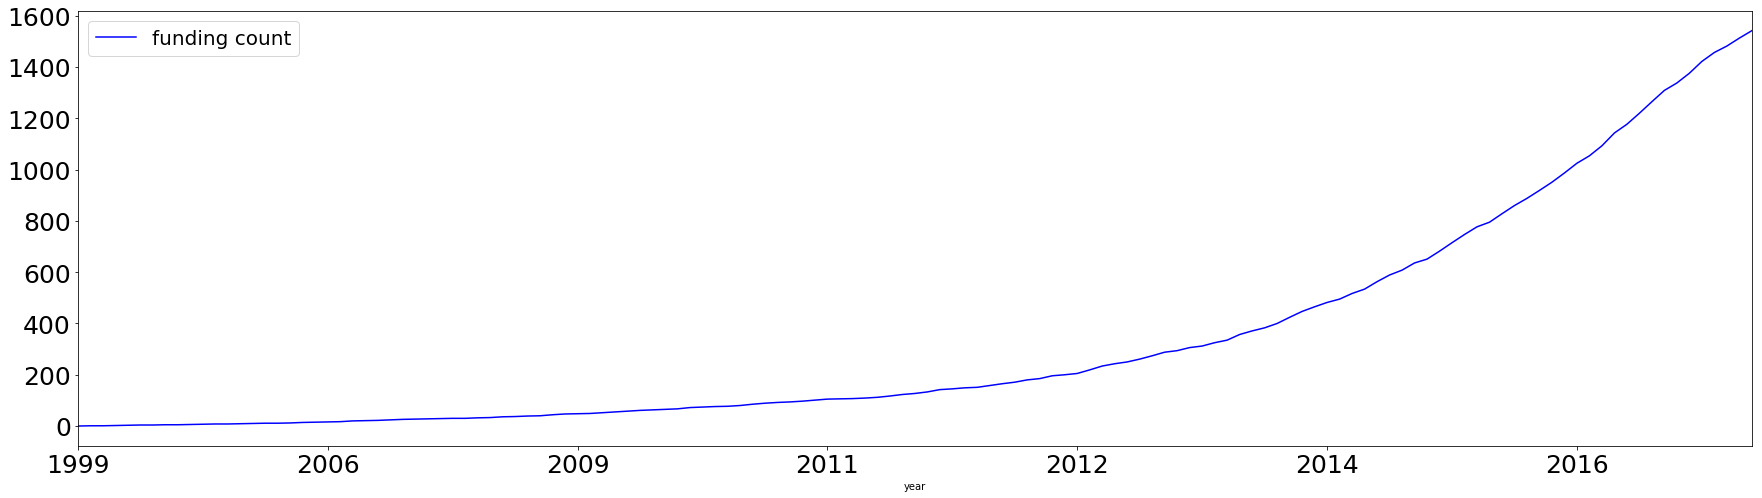

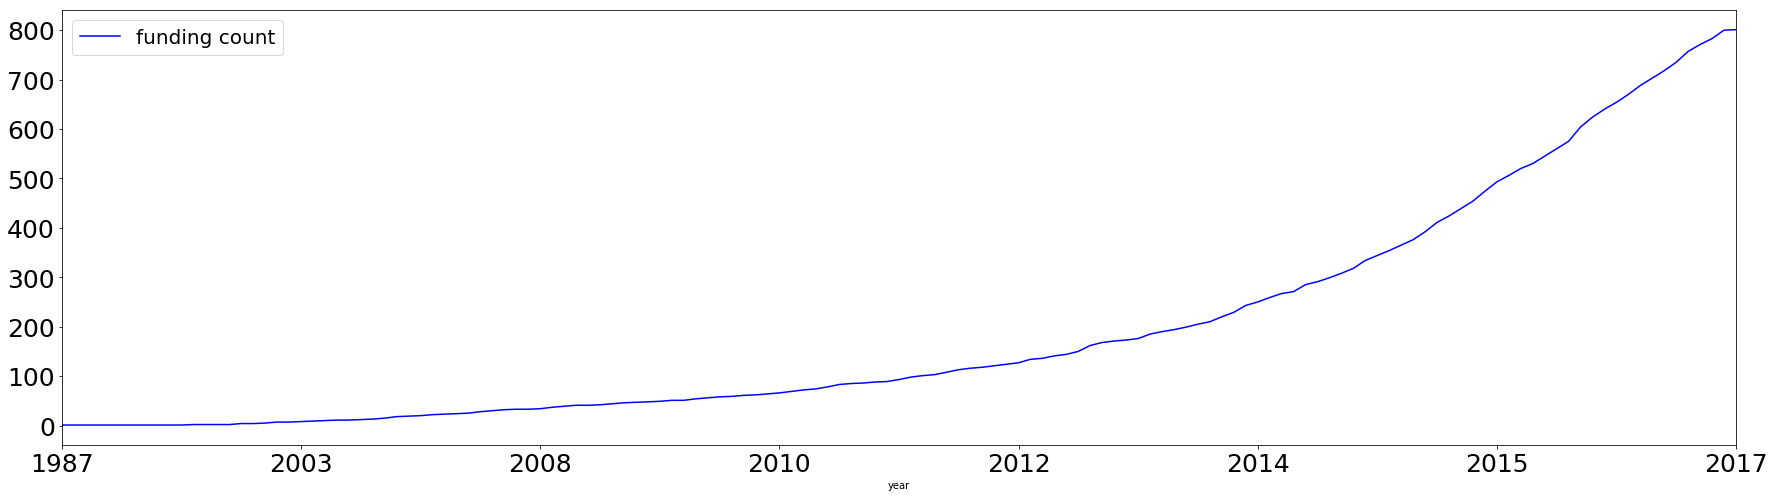

In [99]:
get_early_investors('artificial intelligence', early_investment_percent = 10, top_k = 30)

categories: ['consumer']
Early 10 percent investors before 2003-08-01 
(90 early fundings out of 900 total)
    count                         investor_name     date
0       4                         Goldman Sachs  1999-12
1       4                     Flatiron Partners  2000-05
2       4                           TransCosmos  1999-11
3       4                       Summit Partners  1988-11
4       3                                   TCV  1999-12
5       3                       Lehman Brothers  2000-09
6       3                        J & W Seligman  1999-12
7       3                            HM Capital  1999-08
8       3                        Accel Partners  2000-09
9       3         Draper Fisher Jurvetson (DFJ)  2000-04
10      3                              SoftBank  1998-12
11      3                        August Capital  1999-05
12      3             Internet Healthcare Group  2000-07
13      2                        Bowman Capital  1999-12
14      2                          SS

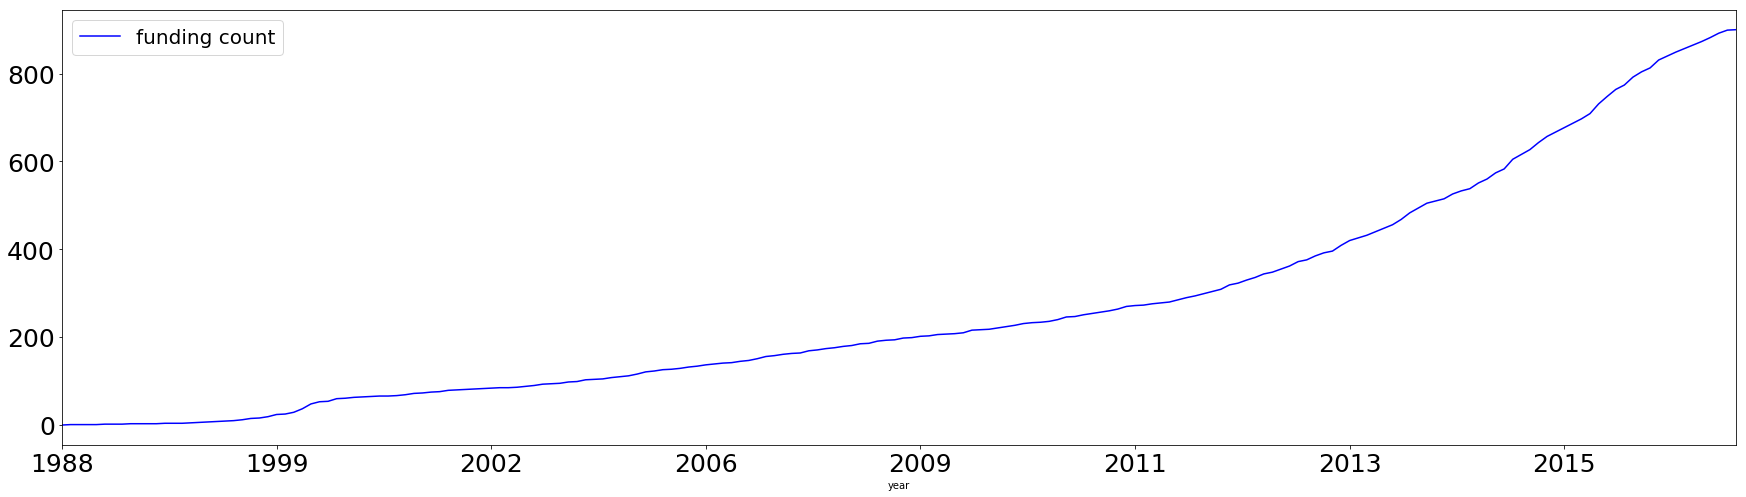

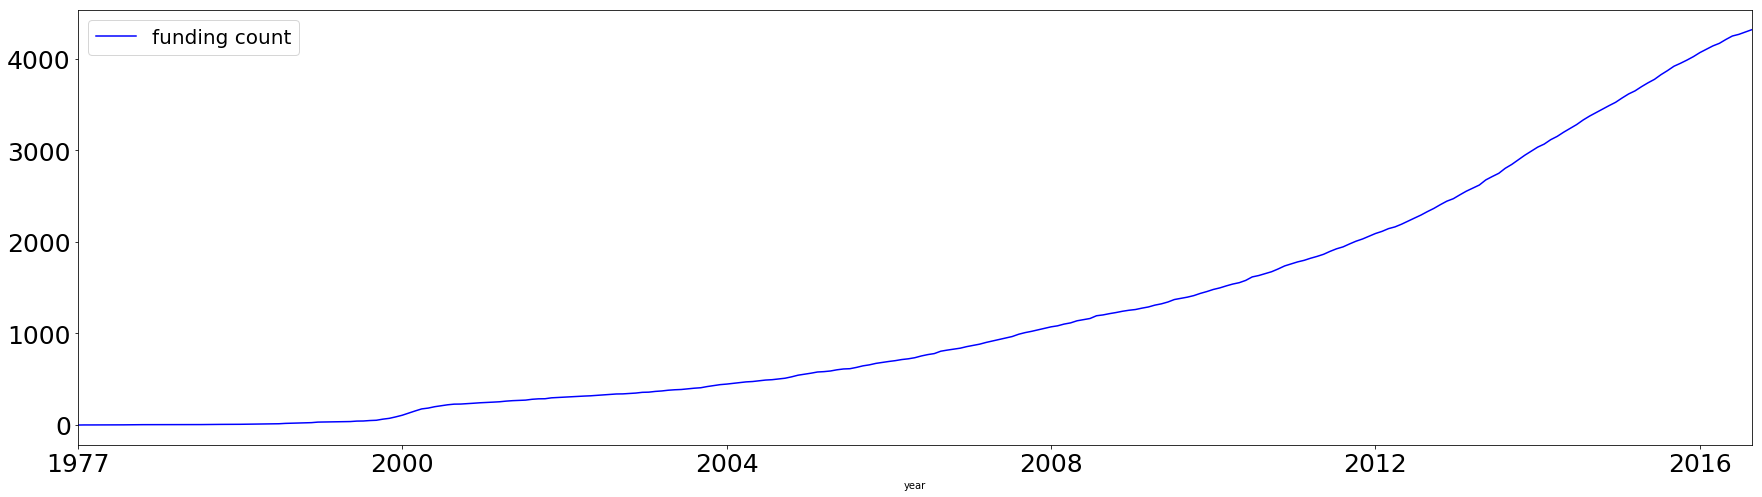

In [100]:
get_early_investors('consumer', early_investment_percent = 10, top_k = 30)

categories: ['health care']
Early 10 percent investors before 2006-02-03 
(1097 early fundings out of 10972 total)
    count                              investor_name     date
0      49                          Domain Associates  1999-02
1      46                  New Enterprise Associates  2000-06
2      44                           Versant Ventures  2000-12
3      32                        Three Arch Partners  2000-03
4      31                                    Venrock  1999-01
5      30  Johnson & Johnson Development Corporation  2000-03
6      29                              Alta Partners  2000-04
7      27                            Summit Partners  1986-05
8      27                                MPM Capital  1999-09
9      26                         InterWest Partners  2000-03
10     26                 Oxford Bioscience Partners  2001-01
11     24                           Polaris Partners  1997-12
12     23                Frazier Healthcare Partners  2000-03
13     23        

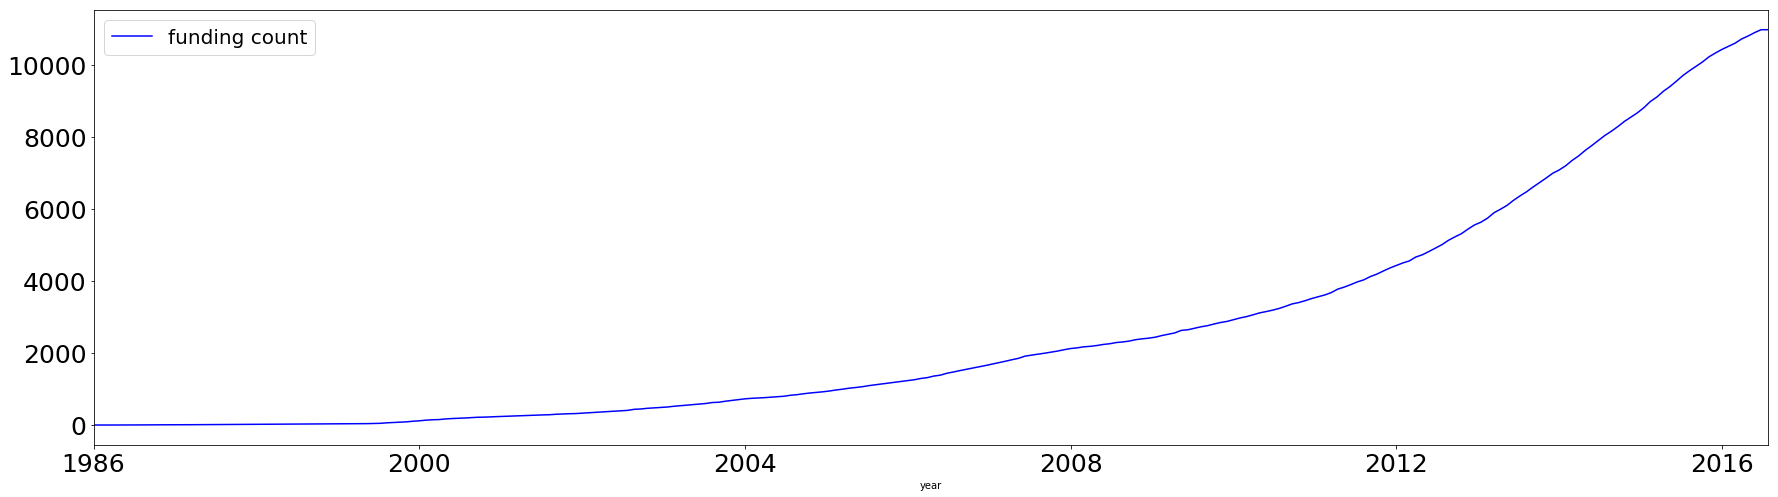

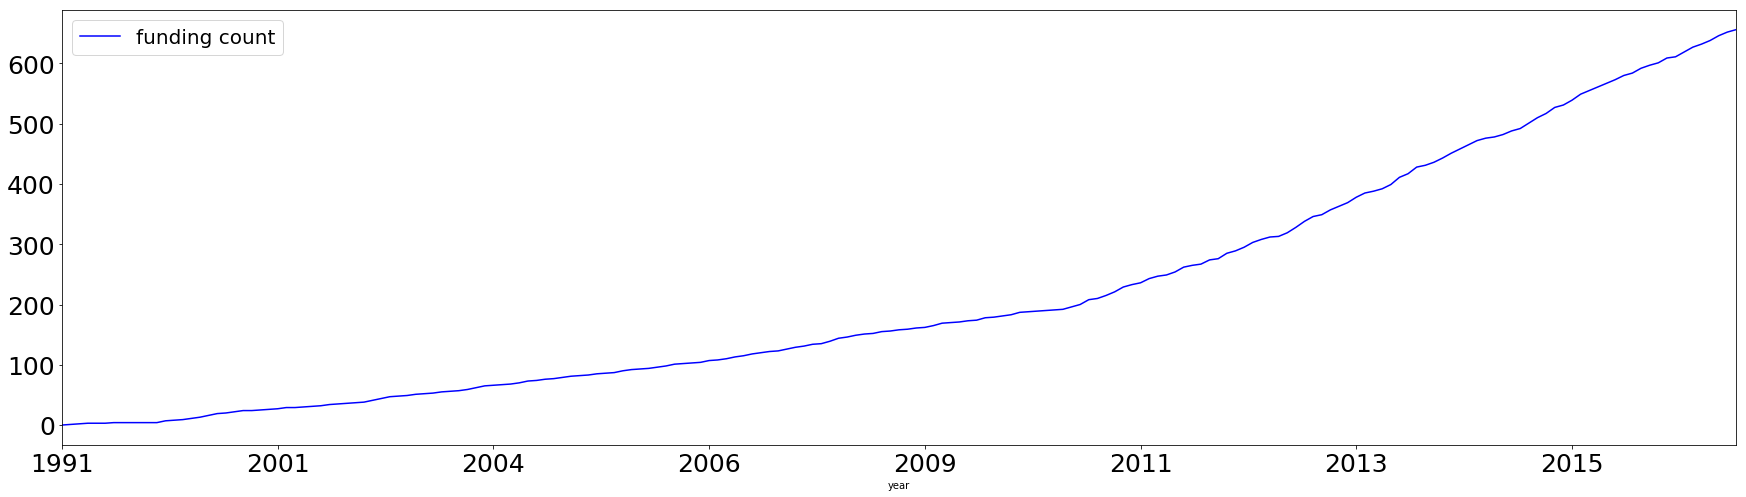

In [101]:
get_early_investors('health care', early_investment_percent = 10, top_k = 30)

categories: ['craft beer']
Early 10 percent investors before 2012-10-25 
(7 early fundings out of 78 total)
   count    investor_name     date
0      2        Crowdcube  2011-10
1      1     The Brandery  2011-08
2      1  Leopard Capital  2011-05
3      1      Maxim Godin  2011-10
4      1      PV Ventures  2010-11
5      1   Consor Capital  2006-11
6      1         Rob Keve  2011-10
7      1   Victor Levitin  2011-10
(8, 3)
Keywords: ['craft_beer']
Early 10 percent investors before 2013-03-21 
(2 early fundings out of 28 total)
   count      investor_name     date
0      1         CrunchFund  2012-01
1      1      David Rusenko  2012-01
2      1  Cavallino Capital  2012-04
(3, 3)


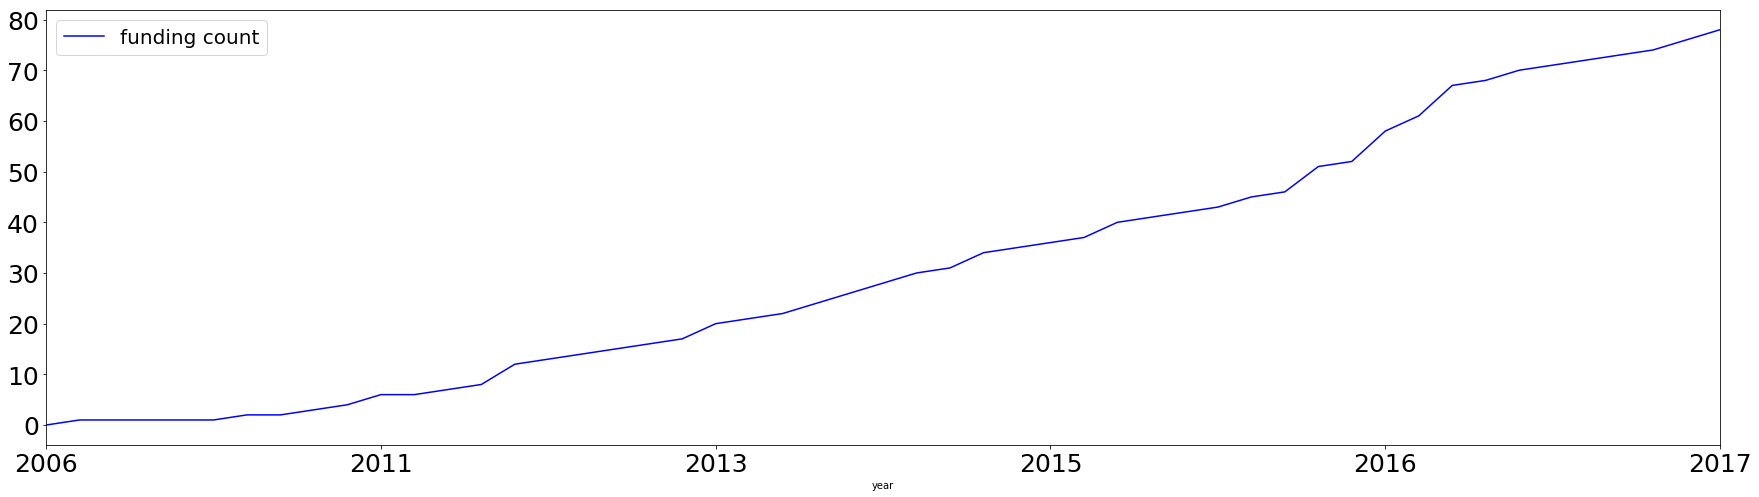

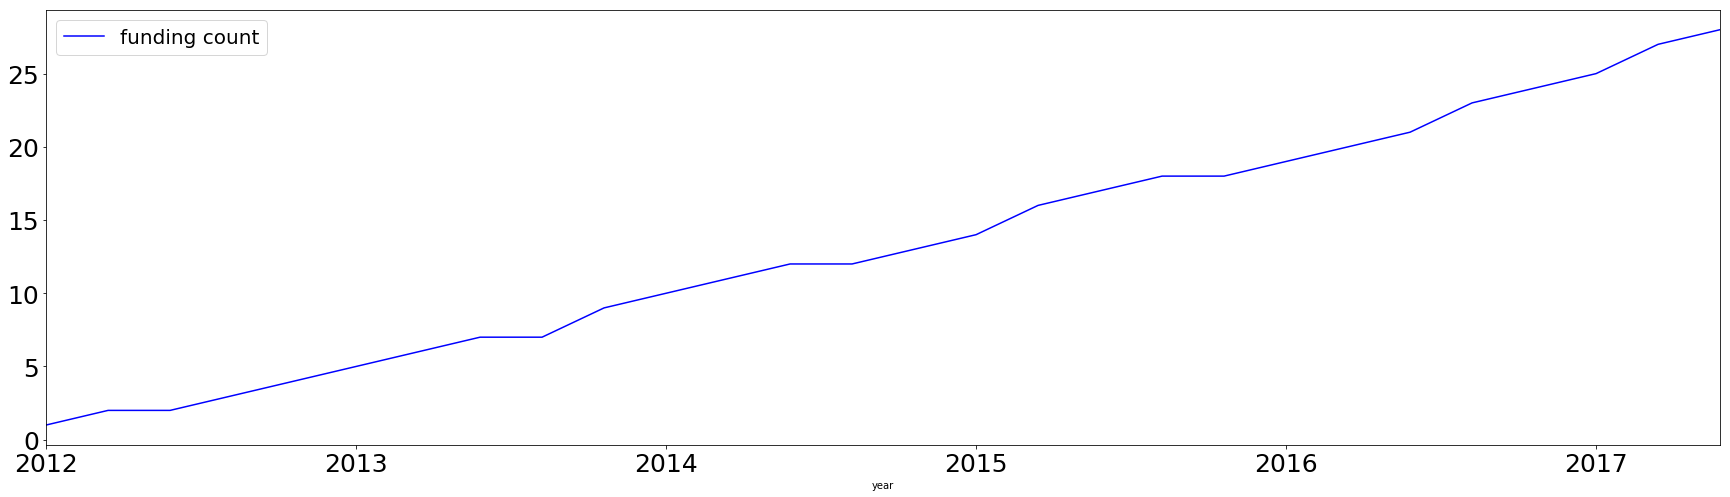

In [104]:
get_early_investors('craft beer', early_investment_percent = 10, top_k = 30)